# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.468420,True,4.560174
1,2.134544,True,8.471678
2,1.160889,True,5.650805
3,-1.028594,False,-0.382374
4,-1.503616,False,-1.383070
...,...,...,...
995,0.951941,False,2.129876
996,0.059147,False,-1.416509
997,-0.087535,False,-1.353154
998,0.443769,True,5.991447


<Axes: xlabel='v0'>

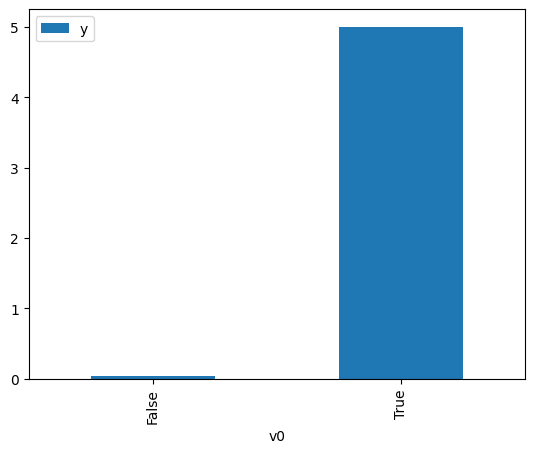

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

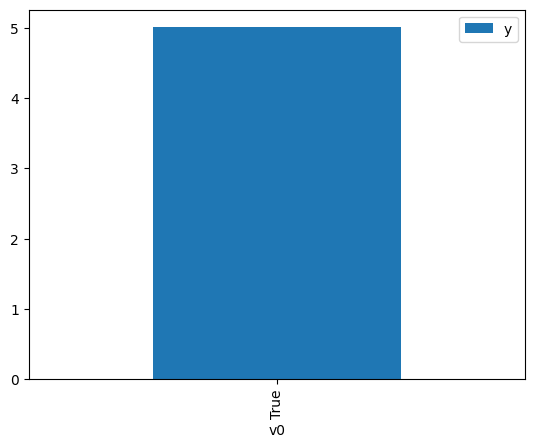

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.610092,False,0.309065,0.342115,2.922994
1,1.489051,False,3.618047,0.159232,6.280152
2,0.656348,False,-1.752405,0.330254,3.027976
3,1.383535,False,2.649717,0.176143,5.677194
4,-0.604523,False,-1.050428,0.677414,1.476201
...,...,...,...,...,...
995,0.092883,False,0.176367,0.485124,2.061330
996,0.340035,False,0.246631,0.414949,2.409933
997,-0.365550,False,-0.366216,0.614743,1.626696
998,0.776515,False,2.665602,0.300455,3.328283


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.800830,True,4.291487,0.705385,1.417666
1,-1.659878,True,0.447393,0.124042,8.061758
2,1.151194,True,5.969224,0.781717,1.279236
3,-0.114654,True,5.189836,0.455376,2.195988
4,-0.784207,True,3.282446,0.279206,3.581579
...,...,...,...,...,...
995,-0.430642,True,4.472772,0.367700,2.719606
996,-0.883674,True,3.784112,0.256793,3.894191
997,1.130201,True,6.885487,0.777572,1.286054
998,0.429377,True,5.257801,0.609738,1.640049


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              9189.
Date:                Sat, 25 Oct 2025   Prob (F-statistic):                        0.00
Time:                        10:34:34   Log-Likelihood:                         -1434.1
No. Observations:                1000   AIC:                                      2872.
Df Residuals:                     998   BIC:                                      2882.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6990      0.035     48.737      0.000       1.631       1.767
x2             5.0145      0.048    103.487      0.000       4.919       5.110
==============================================================================
Omnibus:                        1.694   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.703
Skew:                          -0.100   Prob(JB):                        0.427
Kurtosis:                       2.974   Cond. No.                         1.61
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""